In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
from pymc3 import Continuous
from theano import tensor 
#exp, log, sqrt

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 12

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, gamma, trise, tfall):
    return (A + B*((gamma+t0)-t0))*np.exp(-(t-(gamma+t0))/tfall)/(1+np.exp(-(t-t0)/trise))

In [3]:
#These are the values we are going to use for a test
np.random.seed(212)
trise_A = 9.1
tfall_A = 13
Amplitude_A = 1500
Beta_A = -1
t0_A = 43.2
gamma_A = 60
end_A = 500
size = 10 #data set size double for total observations
sigma_A = 100 #Telescope error

In [4]:
time_axis_rise = np.random.uniform(low=0, high=(gamma_A+t0_A), size=size)
time_axis_rise = np.sort(time_axis_rise)
time_axis_fall = np.random.uniform(low=(gamma_A+t0_A), high=end_A, size=size)
time_axis_fall = np.sort(time_axis_fall)
Y_actual_rise = SuperNova_CurveRise(time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A)
Y_actual_fall = SuperNova_CurveFall(time_axis_fall, Amplitude_A, Beta_A, t0_A, gamma_A, trise_A, tfall_A)
time_axis = np.append(time_axis_rise, time_axis_fall)
Y_actual = np.append(Y_actual_rise, Y_actual_fall)
Y_observed = Y_actual + np.random.normal(0,sigma_A, len(Y_actual))
#Y_observed = Y_actual

Text(0.5, 1.0, 'Actual Light Curve')

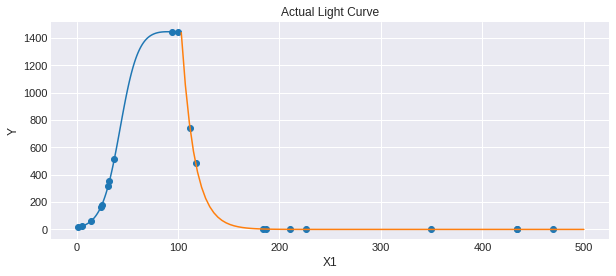

In [5]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_actual)

big_time_axis_rise = np.linspace(0,(gamma_A+t0_A),num = 100)
axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A))

big_time_axis_fall = np.linspace((gamma_A+t0_A),end_A,num = 100)
axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A, Beta_A, t0_A, gamma_A, trise_A, tfall_A))

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Actual Light Curve")

Text(0.5, 1.0, 'Observed Light Curve')

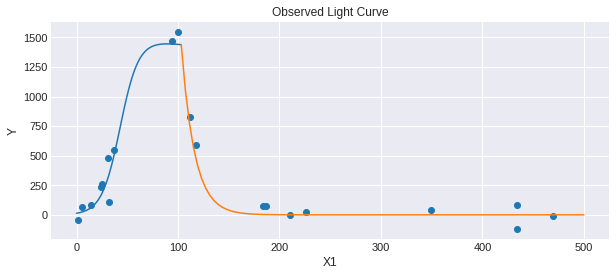

In [6]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_observed)

big_time_axis_rise = np.linspace(0,(gamma_A+t0_A),num = 100)
axes.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A))

big_time_axis_fall = np.linspace((gamma_A+t0_A),end_A,num = 100)
axes.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_A, Beta_A, t0_A, gamma_A, trise_A, tfall_A))

axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

(111.7835330927507, -15.211968197174187)


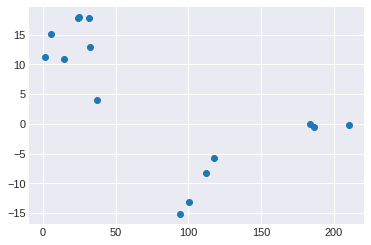

In [7]:
step = int(np.ceil(size/2))
if step<1:
    step = 1
slopes = []
least_slope = (0, 0)
for i in range(len(time_axis)-step):
    if step > 1:
        slope, intercept, r_value, p_value, std_err = stats.linregress(time_axis[i:i+step],Y_observed[i:i+step])
    else:
        slope = (Y_observed[i]-Y_observed[i+step])/(time_axis[i]-time_axis[i+step])
    slopes.append(slope)
    if(slope < least_slope[1]):
        least_slope = (time_axis[i+int(np.floor(step/2))], slope)
print(least_slope)
plt.scatter(time_axis[0:len(time_axis)-step], slopes)

In [8]:
basic_model = pm.Model()

In [9]:
with basic_model:

    # Priors for unknown model parameters
    
    trise = pm.Uniform('trise', lower = 0.01, upper = 50)
    tfall = pm.Uniform('tfall', lower = 1, upper = 300)
    Amp_Guess = np.max(Y_observed)-np.min(Y_observed)
    Amplitude = pm.Normal('Amplitude', mu=Amp_Guess, sigma=Amp_Guess/2)
    Beta = pm.Uniform('Beta', lower = -np.max(Y_observed)/150, upper = 0)
    t0 = pm.Uniform('t0', lower = np.min(time_axis), upper = np.max(time_axis))
    sigma = pm.HalfNormal('sigma', sigma=sigma_A)
    
    #gamma = pm.Uniform('gamma', lower = np.min(time_axis), upper = np.max(time_axis), testval = (least_slope[0]-))
    no_p = pm.Normal.dist(mu = 5, sigma = 5)
    yes_p = pm.Normal.dist(mu = 60, sigma = 30)
    
    gamma = pm.Mixture("gamma", w=[2/3,1/3], comp_dists = [no_p, yes_p])
    #gamma = pm.math.sum(pm.Normal("no_p", mu = 5, sigma = 5),pm.Normal("yes_p", mu = 60, sigma = 30))
    
    # Expected value of outcome
    mu_rise = SuperNova_CurveRise(time_axis, Amplitude, Beta, t0, trise)
    mu_fall = SuperNova_CurveFall(time_axis, Amplitude, Beta, t0, gamma, trise, tfall)
    
    mu_switch = pm.math.switch(gamma+t0 >= time_axis, mu_rise, mu_fall)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed)
    
    

In [10]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -201.04, ||grad|| = 0.036319: 100%|██████████| 109/109 [00:00<00:00, 147.13it/s]


{'trise_interval__': array(27.76718045),
 'tfall_interval__': array(-11.17083902),
 'Amplitude': array(1667.86744022),
 'Beta_interval__': array(-17.82355525),
 't0_interval__': array(0.47209678),
 'sigma_log__': array(6.00729529),
 'gamma': array(56.75161432),
 'trise': array(50.),
 'tfall': array(1.00420951),
 'Beta': array(-10.31593485),
 't0': array(289.59612134),
 'sigma': array(406.38268398)}

In [11]:
with basic_model:
    # 1000 posterior samples
    trace = pm.sample(10000, cores = 6)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [gamma, sigma, t0, Beta, Amplitude, tfall, trise]
Sampling 6 chains, 15 divergences: 100%|██████████| 63000/63000 [03:28<00:00, 302.26draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7071779416357179, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2ac2d7b085c0>,
      dtype=object)

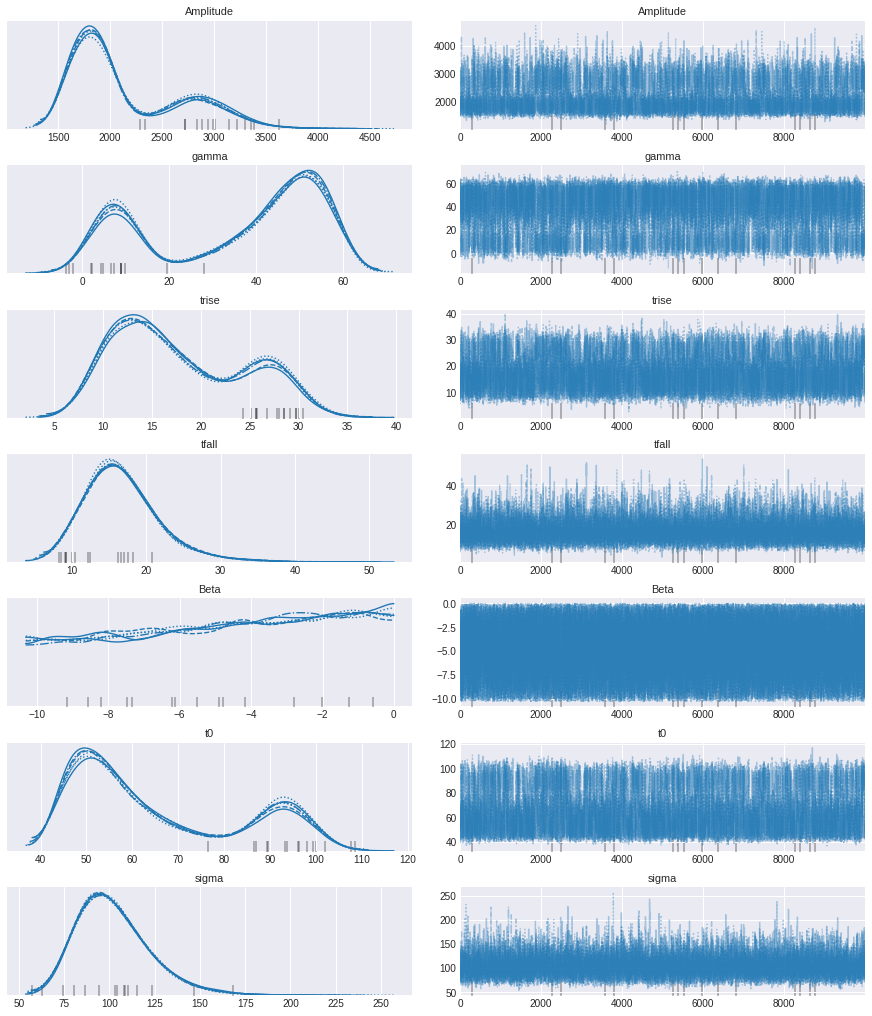

In [13]:
%matplotlib inline
pm.traceplot(trace)

In [14]:
summary_table = pm.summary(trace)
summary_table

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Amplitude,2157.761,541.830,1476.098,3173.180,13.294,9.402,1661.0,1661.0,2172.0,7999.0,1.0
gamma,35.082,19.797,1.846,60.658,0.495,0.350,1597.0,1597.0,2174.0,9303.0,1.0
trise,17.963,6.752,8.061,30.161,0.152,0.110,1985.0,1897.0,2433.0,9313.0,1.0
tfall,16.716,5.042,7.789,25.937,0.046,0.033,11822.0,11524.0,12295.0,14563.0,1.0
Beta,-4.806,2.960,-9.569,-0.000,0.020,0.014,22312.0,21883.0,21032.0,22119.0,1.0
t0,65.499,18.480,42.470,98.581,0.452,0.322,1671.0,1646.0,2235.0,8250.0,1.0
sigma,102.239,19.842,68.697,139.538,0.220,0.156,8128.0,8128.0,8015.0,20088.0,1.0


In [15]:
trise_R = summary_table["mean"]["trise"]
tfall_R = summary_table["mean"]["tfall"]
Amplitude_R = summary_table["mean"]["Amplitude"]
Beta_R = summary_table["mean"]["Beta"]
t0_R = summary_table["mean"]["t0"]
gamma_R = summary_table["mean"]["gamma"]

In [16]:
print(trise_R, trise_A)
print(tfall_R, tfall_A)
print(Amplitude_R, Amplitude_A)
print(Beta_R, Beta_A)
print(t0_R, t0_A)
print(gamma_R, gamma_A)

17.963 9.1
16.716 13
2157.761 1500
-4.806 -1
65.499 43.2
35.082 60


Text(0, 0.5, 'y_observed')

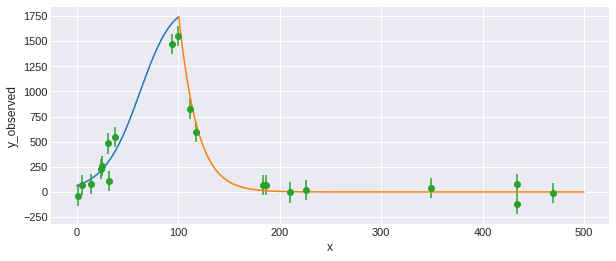

In [17]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t0_R+gamma_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t0_R+gamma_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, gamma_R, trise_R, tfall_R))

ax.errorbar(time_axis, Y_observed, sigma_A, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y_observed')

Text(0, 0.5, 'y_actual')

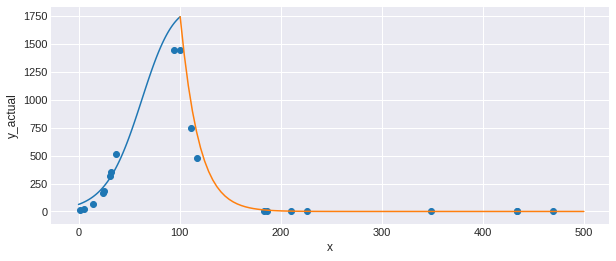

In [18]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t0_R+gamma_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t0_R+gamma_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, gamma_R, trise_R, tfall_R))

ax.scatter(time_axis, Y_actual)
ax.set_xlabel('x')
ax.set_ylabel('y_actual')